In [24]:
from functools import partial
import torch
from models.layers.group_conv import GroupConv

from models.layers.lifting_conv import LiftingConv


class GroupEquivariantCNN(torch.nn.Module):

  def __init__(self, group, in_channels, out_channels, kernel_size, num_hidden, hidden_channels):
    super().__init__()

    # Create the lifing convolution.
    self.lifting_conv = LiftingConv(
        group=group,
        in_channels=in_channels,
        out_channels=hidden_channels,
        kernel_size=kernel_size
    )

    # Create a set of group convolutions.
    self.gconvs = torch.nn.ModuleList()
    for i in range(num_hidden):
      self.gconvs.append(
          GroupConv(
              group=group,
              in_channels=hidden_channels,
              out_channels=hidden_channels,
              kernel_size=kernel_size
          )
      )

    # Create the projection layer.
    self.projection_layer = partial(torch.mean, dim=(-3, -2, -1))

    # And a final linear layer for classification.
    self.final_linear = torch.nn.Linear(hidden_channels, out_channels)

  def forward(self, x):

    # Lift and disentangle features in the input.
    x = self.lifting_conv(x)
    x = torch.nn.functional.layer_norm(x, x.shape[-4:])
    x = torch.nn.functional.relu(x)

    # Apply group convolutions.
    for gconv in self.gconvs:
      x = gconv(x)
      x = torch.nn.functional.layer_norm(x, x.shape[-4:])
      x = torch.nn.functional.relu(x)

    # to ensure equivariance, apply max pooling over group and spatial dims
    x = self.projection_layer(x).squeeze()

    x = self.final_linear(x)
    return x


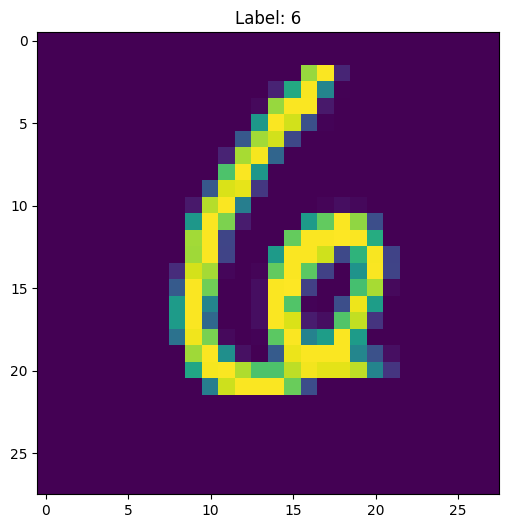

In [25]:
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

train_ds = torchvision.datasets.MNIST(
    root="./datasets", train=False, transform=None)

# Get an image from the test dataset.
digit, label = train_ds[123]

# Turn it into a tensor
digit = transforms.ToTensor()(digit)

plt.figure(figsize=(6, 6))
plt.imshow(digit.squeeze())
plt.title(f'Label: {label}')
plt.show()


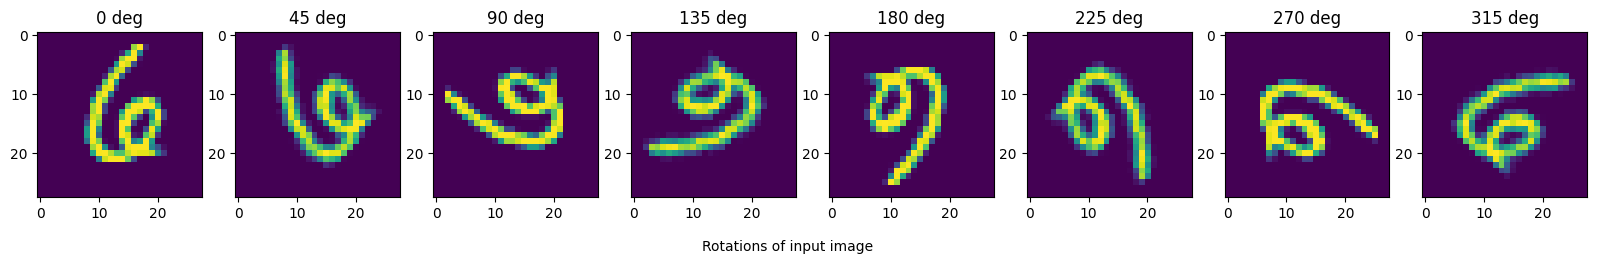

In [26]:
plt.rcParams['figure.figsize'] = [20, 3]

# Get a set of angles by which to rotate this image.
rots = torch.linspace(0, 360 - 360/8, 8)

# Rotate the input image and push it through the normalization transform
rot_digit = torch.stack(tuple(torchvision.transforms.functional.rotate(digit, a.item(
), torchvision.transforms.functional.InterpolationMode.BILINEAR) for a in rots))
rot_digit = torchvision.transforms.Normalize((0.1307,), (0.3081,))(rot_digit)

# Create a subfigure for every rotated input
fig, ax = plt.subplots(1, rots.numel())

for idx, rotation in enumerate(rots):
  ax[idx].imshow(
      rot_digit[idx, :, :].squeeze()
  )
  ax[idx].set_title(f"{int(rotation)} deg")

fig.text(0.5, 0.04, 'Rotations of input image', ha='center')

plt.show()


In [27]:
from groups.discrete_so2 import DiscreteSO2


gcnn_model = GroupEquivariantCNN(group=DiscreteSO2(
    order=4, device="cpu"), in_channels=1, out_channels=10, kernel_size=5, num_hidden=4, hidden_channels=32)


In [28]:

# Forward it through the first few layers of the GCNN
gcnn_out = gcnn_model.lifting_conv(rot_digit)
gcnn_out = torch.nn.functional.relu(
    torch.nn.functional.layer_norm(gcnn_out, gcnn_out.shape[-4:]))
for i in range(2):
  gcnn_out = gcnn_model.gconvs[i](gcnn_out)
  gcnn_out = torch.nn.functional.relu(
      torch.nn.functional.layer_norm(gcnn_out, gcnn_out.shape[-4:]))

# And let's see what happens if we apply the projection on this equivariant representation
projected_gcnn_out = torch.mean(gcnn_out, dim=(-3, -2, -1))


In [29]:


# pick an output channel to visualize
out_channel_idx = 0


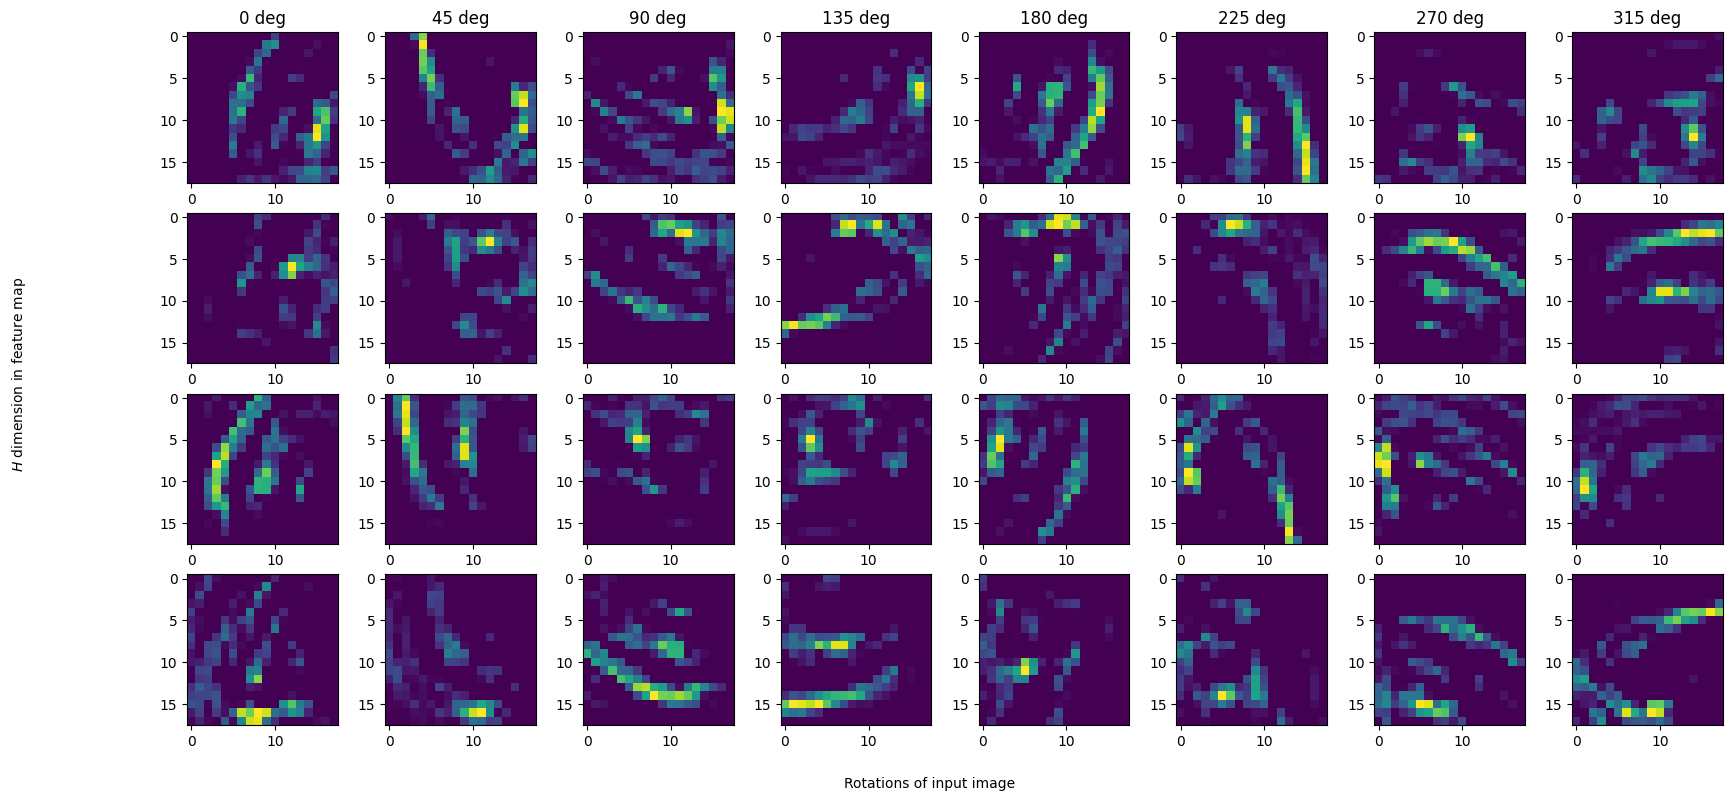

In [30]:
plt.rcParams['figure.figsize'] = [20, 9]

# Pick a channel to visualize
channel_idx = 2

# Create a subfigure for every rotated input and every group element
fig, ax = plt.subplots(gcnn_out.shape[2], rots.numel())

for idx, rotation in enumerate(rots):
  for group_element_idx in range(gcnn_out.shape[2]):
    ax[group_element_idx, idx].imshow(
        gcnn_out[idx, out_channel_idx, group_element_idx, :, :].detach().numpy()
    )
  ax[0, idx].set_title(f"{int(rotation)} deg")


fig.text(0.5, 0.04, 'Rotations of input image', ha='center')
fig.text(0.04, 0.5, '$H$ dimension in feature map',
         va='center', rotation='vertical')

plt.show()


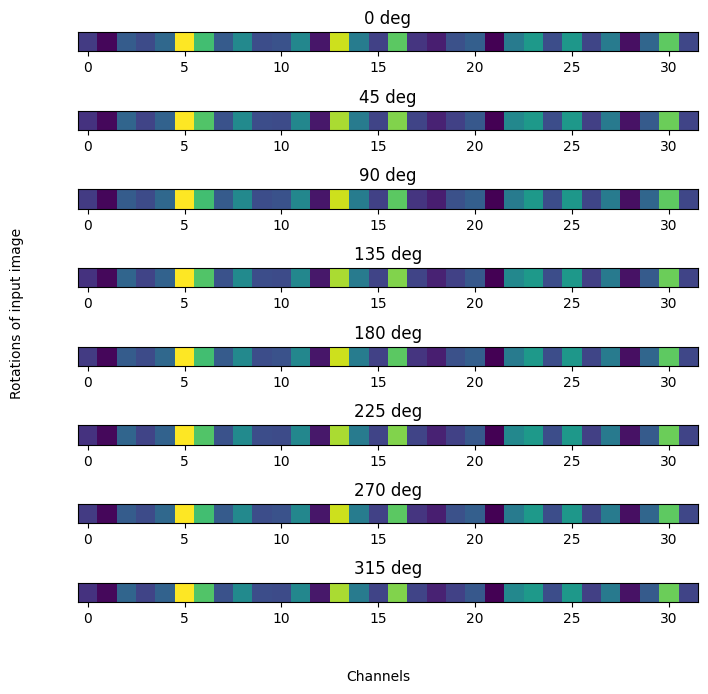

In [31]:
plt.rcParams['figure.figsize'] = [8, 8]

# Create a subfigure for every rotated input
fig, ax = plt.subplots(rots.numel(), 1)

for idx, rotation in enumerate(rots):
  ax[idx].imshow(
      projected_gcnn_out[idx, None, :].detach().numpy()
  )
  ax[idx].set_title(f"{int(rotation)} deg")
  ax[idx].set_yticks([])

fig.text(0.5, 0.04, 'Channels', ha='center')
fig.text(0.04, 0.5, 'Rotations of input image',
         va='center', rotation='vertical')

plt.show()
